In [1]:
import sys
import os
sys.path.append("/home/vtrappler/")
sys.path.append("/home/vtrappler/qgs/")

import warnings
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from numba.core.errors import NumbaPerformanceWarning

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)
# m = n * (nobs + 1)
from common.numerical_model import NumericalModel
from common.observation_operator import IdentityObservationOperator
from dynamical_systems.quasigeostrophic_numerical_model import create_QG_model

plt.style.use("seaborn")
plt.set_cmap('magma')
from qgs.QG import QGwrapper

# Let us set a rng for reproducibility
rng = np.random.default_rng(seed=93)

qg_model = QGwrapper(wavenumbers=(3, 2), tsteps=0.05, write_steps=1, dt=0.01)
qg_model.configure(tangent_linear=True)
qg_model.burn_model(burn=20_000)

Number of (spectral) parameters = 2y*(2x+1) = 28
Number of grid points = 4x+2, 4y+2 = (14, 10) = 140
Number of saved points: 6


<Figure size 576x396 with 0 Axes>

In [2]:
# plt.subplot(1, 2, 1)
# plt.imshow(np.cov(traj))
# plt.subplot(1, 2, 2)
# plt.imshow(np.linalg.inv(np.cov(traj)))
# np.linalg.slogdet(np.cov(traj))

In [3]:
import os
if not os.path.exists(f'Binv_{qg_model.x}_{qg_model.y}.npy'):
    time, traj = qg_model.forward(qg_model.initial_conditions, tsteps=10_000, write_steps=10)
    print(traj.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(np.cov(traj))
    plt.subplot(1, 2, 2)
    plt.imshow(np.linalg.inv(np.cov(traj)))
    np.linalg.slogdet(np.cov(traj))
    np.save(f"./Binv_{qg_model.x}_{qg_model.y}.npy", np.linalg.inv(np.cov(traj)))

In [4]:
# ## Run model for 1 day
# qg_model.change_settings(tsteps=0.5 * qg_model.tstep_1day, write_steps=1, dt=None)
# GN, (time, _, _) = qg_model.GaussNewtonMatrix(qg_model.initial_conditions)
# slogdet = np.linalg.slogdet(GN)
# print(slogdet, np.linalg.cond(GN))
# plt.subplot(1, 2, 1)
# plt.title(np.linalg.slogdet(GN))
# plt.imshow(GN)
# plt.subplot(1, 2, 2)
# plt.title(np.linalg.cond(GN))
# plt.plot(np.linalg.eigvalsh(GN))
# plt.yscale("log")
# plt.tight_layout()

# t, traj, jacobian_ = qg_model.forward_jacobian(x=qg_model.initial_conditions)
# jacobian = jacobian_[:, :, -1]

In [5]:
from common.observation_operator import RandomObservationOperator


tsteps = qg_model.tstep_1day * 3.0
qg_model.change_settings(tsteps=tsteps, write_steps=1, dt=None)
print(f"{(tsteps / qg_model.tstep_1day) * 24:.2f} hours")
obs_operator = IdentityObservationOperator(qg_model.spectral_dim, qg_model.spectral_dim)
obs_operator = RandomObservationOperator(qg_model.spectral_dim, qg_model.spectral_dim, type='square', p=0.5)


qg_model.generate_obs(qg_model.initial_conditions + 0.2, 1)

Binv = np.load(f"Binv_{qg_model.x}_{qg_model.y}.npy")
L = np.linalg.cholesky(np.linalg.inv(Binv))

background = np.zeros(qg_model.spectral_dim), Binv, L
# background = None
# model, sp_fun, gn_fun = create_QG_model(qg_model, obs_operator=obs_operator, background=background, test=False, gnparams=(50, 10, 0.1))
model = create_QG_model(qg_model, obs_operator=obs_operator, background=background, test=False, gnparams=(50, 10, 0.1))

x0 = np.zeros(qg_model.spectral_dim)

tsteps is overwritten
Previous tsteps: 20000
New tsteps: 26.74944 (3.000 days)
writesteps is overwritten
Previous write_steps: 0
New write_steps: 1
72.00 hours


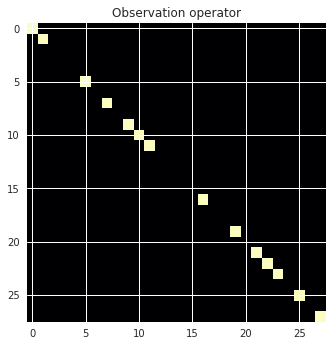

In [6]:
obs_operator.H.shape
plt.title(r"Observation operator")
plt.imshow(obs_operator.H)

niter,     f(x),  CG iter, log-det,   cond
    0,  12.4776,       10, 214.13, 3.4497e+02
    1,  12.8920,       10, 214.02, 3.4937e+02
    2,  13.3593,       10, 214.30, 3.4253e+02
scipy: 12.468683911201087
GN: 13.35927013441579


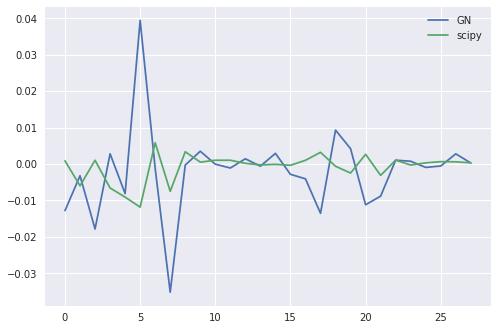

In [7]:
import scipy
qg_model.generate_obs(qg_model.initial_conditions + np.random.normal(size=qg_model.spectral_dim), 1)
model.set_obs(qg_model.obs)
res = model.GNmethod(np.zeros(qg_model.spectral_dim), n_outer=3, n_inner=10, verbose=True)
sp_opt = scipy.optimize.minimize(model.cost_function, x0)
sp_x, sp_fun = sp_opt.x, sp_opt.fun
print(f"scipy: {sp_fun}")
print(f"GN: {res[1]}")
plt.plot(res[0], label='GN')
plt.plot(sp_x, label='scipy')
plt.legend()
GN_no_prec = res[0]

niter,     f(x),  CG iter, log-det,   cond
    0,  12.4946,        5,   2.00, 4.2849e+00
    1,  12.9706,        6,   2.51, 4.7684e+00
    2,  12.8450,        5,   1.17, 2.6385e+00
scipy: 12.468683911201087
GN: 13.35927013441579


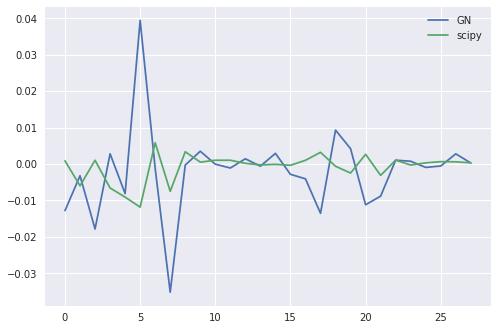

In [8]:
res_prec = model.GNmethod(np.zeros(qg_model.spectral_dim), n_outer=3, n_inner=10, verbose=True, prec="bck")
print(f"scipy: {sp_fun}")
print(f"GN: {res[1]}")
plt.plot(res[0], label='GN')
plt.plot(sp_x, label='scipy')
plt.legend()

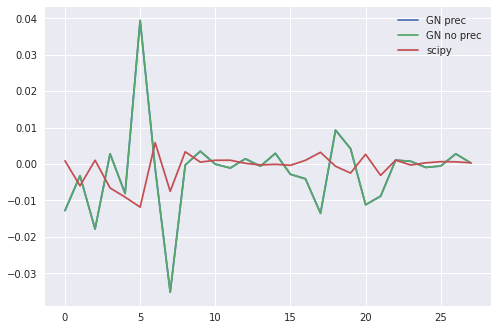

In [9]:
plt.plot(res[0], label='GN prec')
plt.plot(GN_no_prec, label='GN no prec')
plt.plot(sp_x, label='scipy')
plt.legend()

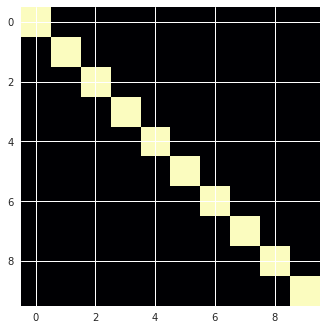

In [10]:
import numpy as np
S = np.random.normal(size=(10, 3))
H = np.eye(10) + S @ S.T
Hm1 = np.eye(10) - S @ np.linalg.inv(np.eye(3) + S.T @ S) @ S.T
plt.imshow(H @ Hm1)

In [11]:
import scipy
for _ in range(5):
    print(scipy.optimize.check_grad(model.cost_function, model.gradient, x0=np.random.normal(size=qg_model.spectral_dim)))

9372956517100.031
65440078489.50455
3097144697419997.0
2970753018238.519
9.092769724616277e+23


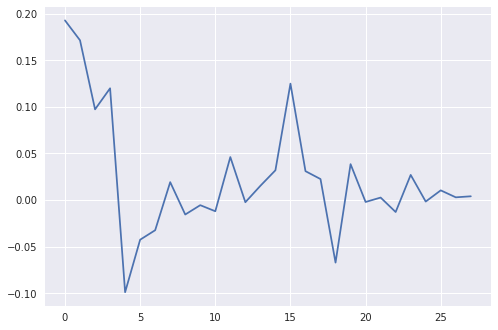

In [12]:
plt.plot(qg_model.initial_conditions)

In [13]:
qg_model.generate_obs(qg_model.initial_conditions + 0.2, 0.01)

In [14]:
eps = 1e-7
x_ = np.random.normal(size=(qg_model.spectral_dim))
cost = qg_model.cost_function(x_)
grad_fd = []
for i in tqdm.trange(qg_model.spectral_dim):
    e = np.zeros(qg_model.spectral_dim)
    e[i] = 1
    grad_fd.append((qg_model.cost_function(x_ + eps * e) - cost) / eps)

100%|██████████| 28/28 [00:01<00:00, 15.48it/s]


In [15]:
grad = qg_model.gradient(x_)
np.array(grad_fd)/grad

array([ 6.90373067e-10, -3.27785958e-10, -1.93408275e-09,  4.89712406e-10,
       -1.08850568e-09, -1.34376632e-10,  3.82760851e-09, -4.26207277e-09,
       -1.43230703e-09, -8.22362785e-10, -2.46160854e-10,  9.60084038e-10,
       -1.45805772e-11, -6.04388392e-10,  1.01619554e-09,  9.30376953e-09,
       -2.26422016e-10, -1.19078782e-09, -7.18841236e-11,  6.67676092e-10,
       -2.77941422e-09,  3.03270340e-10, -1.21205573e-10,  1.23739752e-10,
        3.35612166e-10, -6.63763343e-11,  1.29956966e-09, -4.53548677e-10])

In [16]:
print(np.array(grad_fd).min(), np.array(grad_fd).max())
print(grad.min(), grad.max())

-2824839.7624278395 4132028.712556716
-5298966932870782.0 1.2616175524437166e+16


In [17]:
t, traj, jac = qg_model.forward_jacobian(qg_model.initial_conditions)
jac = jac[..., -1]
GN2 = jac.T @ jac

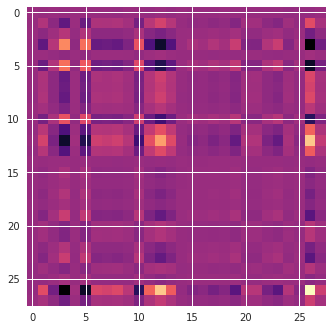

In [18]:
GN, _ = qg_model.GaussNewtonMatrix(qg_model.initial_conditions)

plt.imshow(GN)

In [19]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']